# Import Modules

In [2]:
import torch
import numpy as np
from PIL import Image, ImageTk
import matplotlib
import matplotlib.pyplot as plt
import os
import cv2
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter
import easyocr

# Display Contour Of Plate On Image

In [3]:
def retrun_final_image_with_box(modelpath, imgpath, lblpath, min_conf=0.5):

  # Grab filenames of all images in test folder

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5




  image_path=imgpath

  # Loop over every image and perform detection

      # Load image and resize to expected shape [1xHxWx3]
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imH, imW, _ = image.shape
  image_resized = cv2.resize(image_rgb, (width, height))
  input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
  if float_input:
      input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
  interpreter.set_tensor(input_details[0]['index'],input_data)
  interpreter.invoke()

      # Retrieve detection results
  boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
  classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
  scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

  detections = []
  intersting_boxes=[]

      # Loop over all detections and draw detection box if confidence is above minimum threshold
  for i in range(len(scores)):
      if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
          ymin = int(max(1,(boxes[i][0] * imH)))
          xmin = int(max(1,(boxes[i][1] * imW)))
          ymax = int(min(imH,(boxes[i][2] * imH)))
          xmax = int(min(imW,(boxes[i][3] * imW)))

          intersting_boxes.append(boxes[i])

          cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
          object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
          label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
          labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
          label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
          cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
          cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

          detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])

          image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

  return image,intersting_boxes







  


# EXAMPLE

In [4]:
PATH_TO_IMAGES="images/test/cars419.png"
PATH_TO_MODEL='D:\mes projets\Automatic plate number recognition\custom_model_lite\detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='D:\mes projets\Automatic plate number recognition\custom_model_lite\labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.75  # Confidence threshold (try changing this to 0.01 if you don't see any detection results)

image,boxes=retrun_final_image_with_box(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf=min_conf_threshold)

# Display Result

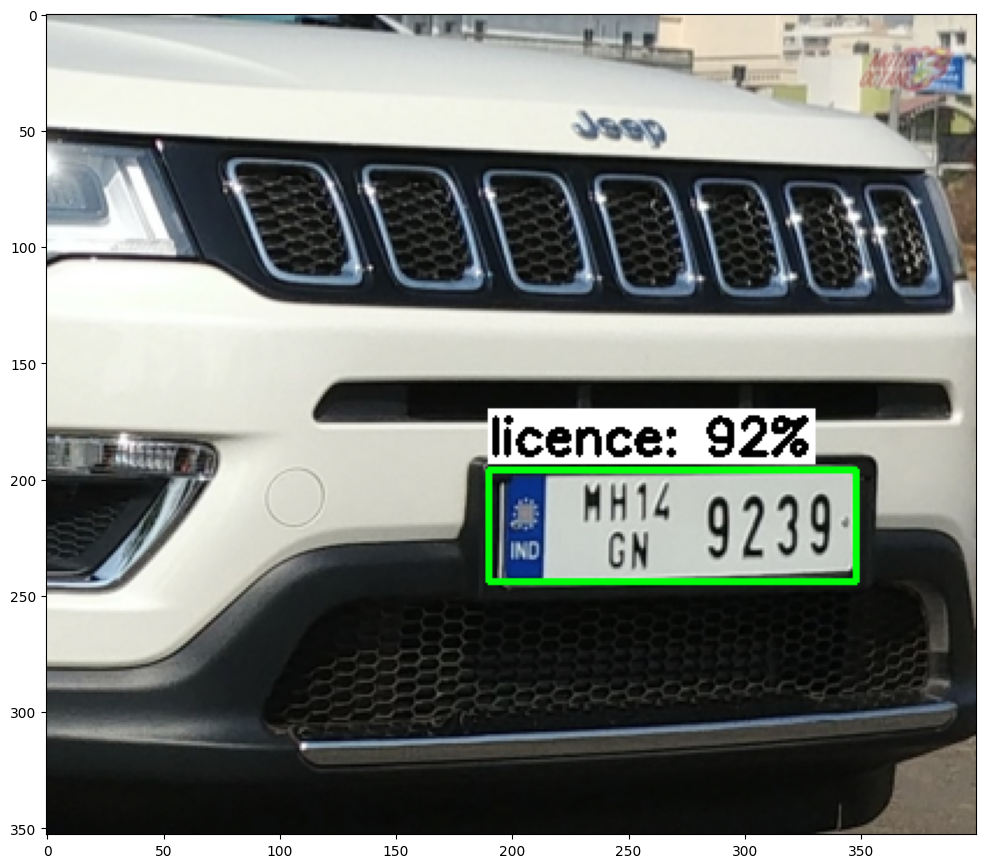

In [5]:

plt.figure(figsize=(12,16))
plt.imshow(image)

In [13]:
def get_text_from_plate(image,boxes,region_threshold=0.3):
      """
    Extracts the text from an image of a car's license plate using OCR (esasyocr).
    
    Args:
        image_path (str): The file path to the image containing the car with car's licence encadred.
        boxes: list that contains coordinate of the rectangle that delimited the licence (it may contains other rectangles if the model commited errors)
        region_threshold (float): Threshold for the area ratio of the region containing text
                                  to the area of the whole license plate. If the ratio exceeds
                                  this threshold, the extracted text will be displayed.    
    Returns:
        str: The extracted text from the license plate.
    """
    width = image.shape[1]
    height = image.shape[0]
    plate=[]
    for idx, box in enumerate(boxes):

        roi = box*[height, width, height, width]
 
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en']) # la langue est anglais "en"
        ocr_result = reader.readtext(region)
        rectangle_area = region.shape[0]*region.shape[1]
        for result in ocr_result:
            length = np.sum(np.subtract(result[0][1], result[0][0]))
            height = np.sum(np.subtract(result[0][2], result[0][1]))
        
            if length*height / rectangle_area > region_threshold:
                plate.append(result[1])
    return "".join(plate)

In [15]:
print(get_text_from_plate(image,boxes,0.1))

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


MHIL9239
